In [1]:
import numpy as np
import matplotlib 
import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf as pltSave
import matplotlib.ticker as ticker
import seaborn as sns
import helper_fcns as hlp
import autoreload
import os
from scipy.stats import norm, wilcoxon
matplotlib.style.use('plt_style.mplstyle')
%matplotlib inline

In [2]:
dataDir = 'data/';
saveDir = dataDir + 'results/';
disp = 3;
isGeorgeson = 0;
if isGeorgeson:
    whichFiles = 'toAnalyzeD' + str(disp) + 'g.txt';
else:
    whichFiles = 'toAnalyzeD' + str(disp) + '.txt';
dataList = open(dataDir + whichFiles, 'r')
dFilesAll = dataList.readlines(-1)
dFilesAll = [x.strip('\n') for x in dFilesAll]
dataList.close()

In [3]:
if not isGeorgeson:
    if disp == 1:
        dFiles = dFilesAll[4:]; # ignore the first 4 sessions - early training
    elif disp == 3:
        dFiles = dFilesAll[1:];
    elif disp == 5:
        dFiles = dFilesAll[2:]; # ignore first 2
else:
    dFiles = dFilesAll;

In [4]:
sfIdx = 0;
conIdx = 1;
dispIdx = 2;
nInd = 3; # 3 indices per stimulus; add 3 to all of the above indices to get the equivalent value for the second stimulus
subjRespIdx = 2*nInd;
refIdx = subjRespIdx + 1; # which interval contained reference is after the subject's response in the data format

In [5]:
stim1 = 39; stim2 = 41; # subject responses (asked which stimulus has higher SF)

In [6]:
data = [];
for df in dFiles:
    currData = np.loadtxt(dataDir + df);
    if df == dFiles[0]:
        data = currData;
    else:
        data = np.concatenate((data, currData), axis = 0);

sfVals = np.union1d(np.unique(data[:, sfIdx]), np.unique(data[:, sfIdx+nInd]))
conVals = np.union1d(np.unique(data[:, conIdx]), np.unique(data[:, conIdx+nInd]))
nCons = len(conVals);
dispVals = np.union1d(np.unique(data[:, dispIdx]), np.unique(data[:, dispIdx+nInd]))

In [7]:
allResp = data[:, subjRespIdx];
if any((allResp != stim1) & (allResp != stim2)):
    print('Problem: response which is neither 1 or 2')

In [8]:
s1g = data[:, sfIdx] > data[:, sfIdx+nInd];
s2g = data[:, sfIdx] < data[:, sfIdx+nInd]

In [9]:
# find which one is the reference (as opposed to test) grating
ref = np.zeros(data.shape[0])
ref = data[:, refIdx]

# allows for possibility of more than one refSf...
refSF = np.union1d(np.unique(data[ref==1, sfIdx]), np.unique(data[ref==2, sfIdx+nInd]))

In [10]:
# did the subject perceive the test as higher SF?
testHF = np.zeros(data.shape[0]);
testHF[ref==1] = data[ref==1, subjRespIdx] == stim2;
testHF[ref==2] = data[ref==2, subjRespIdx] == stim1;

In [11]:
testCons = np.zeros(data.shape[0])
testCons[ref==1] = data[ref==1, nInd+conIdx];
testCons[ref==2] = data[ref==2, conIdx];

In [12]:
testSfs = np.zeros(data.shape[0])
testSfs[ref==1] = data[ref==1, nInd+sfIdx];
testSfs[ref==2] = data[ref==2, sfIdx];

In [13]:
checkz = np.zeros((len(testSfs), 1));
for i in range(len(sfVals)):
    checkz[testSfs == sfVals[i]] = 1;

In [14]:
# data analysis - number of trials/responses "test>ref sf", fraction "test>ref" split by sf/con
ptSf, nTr, nTestResp = (np.zeros((nCons, len(sfVals))) for _ in range(3));
for con in range(nCons):
    for sf in range(len(sfVals)):
        z = (testSfs == sfVals[sf]) & (testCons == conVals[con]) # get trials with the desired test sf/con
        nTr[con][sf] = sum(z); # how many trials in this configuration
        nTestResp[con][sf] = sum(testHF[z]) # how many trials in this configuration with response "test > ref sf"
        ptSf[con][sf] = nTestResp[con][sf] / nTr[con][sf]
    print('Con ' + str(conVals[con]) + ': ' + str(sum(nTr[con])) + ' trials')

Con 0.05: 224.0 trials
Con 0.1: 239.0 trials
Con 0.33: 226.0 trials
Con 1.0: 211.0 trials


In [15]:
# optimize and bootstrap
nFits = 5; # don't think you need multistart, but build it in anyway
bootIter = 100; # set to 0 for no bootstrap
univ_params = 2; # number of "universal parameters", i.e. for all pmf
nParams = nCons + univ_params; # one mean for each contrast; overall slope, lapse
bootTestResps = np.zeros((nCons, len(nTestResp[0]), bootIter))
loss = np.zeros((nCons, 1)); # only one loss value...

opt = hlp.opt_pmf(sfVals, nTestResp, nTr, norm.cdf, nFits);

params = np.zeros((nCons, univ_params+1)) # 3+1 params per PMF
for c in range(nCons): # now unpack...
    params[c, 0] = opt['x'][c];
    params[c, 1:] = opt['x'][nCons:];
    # expand dimensions of nTestResp so that pmf_loss knows there is only one contrast value to explore
    loss[c] = hlp.pmf_loss(sfVals, np.expand_dims(nTestResp[c], 0), np.expand_dims(nTr[c], 0),
                           norm.cdf, params[c, 0], params[c, 1], params[c, 2]);
    
paramsBoot = np.zeros((nCons, univ_params+1, bootIter));
for iter in range(bootIter):
    bootTestResps[:, :, iter] = np.random.binomial(nTr.astype('int64'), ptSf)
    # expand dimensions of bootTestResps so that pmf_loss knows there is only one contrast value to explore
    optBoot = hlp.opt_pmf(sfVals, bootTestResps[:, :, iter], nTr, norm.cdf, 1)
    # unpack paramters
    for c in range(nCons):
        paramsBoot[c, 0, iter] = optBoot['x'][c];
        paramsBoot[c, 1:, iter] = optBoot['x'][nCons:];

In [16]:
# compute from bootstrap values...
bootParamMean = paramsBoot.mean(-1);
bootParamStd = paramsBoot.std(-1);

# reshape number of trials by con/sf so we can get bootstrap estimates of subject's proportion responses "test>ref"
bootPtSf = bootTestResps / np.repeat(nTr.reshape((len(conVals), len(nTestResp[0]), 1)), 100, axis=-1); 
bootPtSfmean = bootPtSf.mean(-1);
bootPtSfstd = bootPtSf.std(-1);

### Plot of psychometric function and measured responses

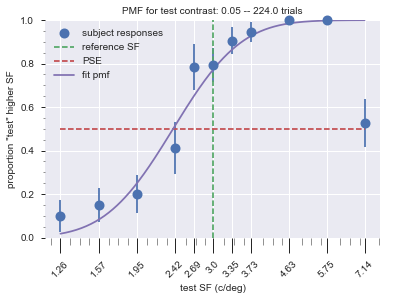

In [17]:
# now plot the PMF
whichCon = 0;
x = np.log2(np.arange(sfVals[0], sfVals[-1], 1e-2));
true_pmf = lambda params: params[2] + (1-2*params[2])*norm.cdf(x, *params[0:2])

#sns.set_style("dark")

pts = plt.errorbar(np.log2(sfVals), ptSf[whichCon], yerr=bootPtSfstd[whichCon, :], clip_on=False, linestyle='none', marker='o');
refSFline = plt.plot(np.log2([refSF, refSF]), [0, 1], '--'); 
pse = plt.plot(np.log2([sfVals[0], sfVals[-1]]), [0.5, 0.5], '--')
pmf = plt.plot(x, true_pmf(params[whichCon, :]), '-');
plt.ylim([0, 1]);
sfAsStr = [str(x) for x in np.round(sfVals, 2)];
plt.xticks(np.log2(sfVals), sfAsStr, rotation='45')
plt.xlabel('test SF (c/deg)');
plt.ylabel('proportion "test" higher SF');
plt.legend((pts[0], refSFline[0], pse[0], pmf[0]), ('subject responses', 'reference SF', 'PSE', 'fit pmf'));
plt.title('PMF for test contrast: ' + str(conVals[whichCon]) + ' -- ' + str(sum(nTr[whichCon])) + ' trials');

### Comparison of two contrasts

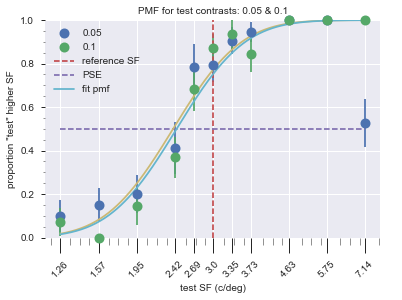

In [18]:
con1 = 0; con2 = 1;
x = np.log2(np.arange(sfVals[0], sfVals[-1], 1e-2))
true_pmf = lambda params: params[2] + (1-2*params[2])*norm.cdf(x, *params[0:2])

pts = plt.errorbar(np.log2(sfVals), ptSf[con1], yerr=bootPtSfstd[con1, :], clip_on=False, linestyle='none', marker='o');
pts2 = plt.errorbar(np.log2(sfVals), ptSf[con2], yerr=bootPtSfstd[con2, :], clip_on=False, linestyle='none', marker='o');
refSFline = plt.plot(np.log2([refSF, refSF]), [0, 1], '--'); 
pse = plt.plot(np.log2([sfVals[0], sfVals[-1]]), [0.5, 0.5], '--')
pmf = plt.plot(x, true_pmf(params[con1, :]), '-');
pmf = plt.plot(x, true_pmf(params[con2, :]), '-');
plt.ylim([0, 1]);
sfAsStr = [str(x) for x in np.round(sfVals, 2)];
plt.xticks(np.log2(sfVals), sfAsStr, rotation='45')
plt.xlabel('test SF (c/deg)');
plt.ylabel('proportion "test" higher SF');
plt.legend((pts[0], pts2[0], refSFline[0], pse[0], pmf[0]), (str(conVals[con1]), str(conVals[con2]), 'reference SF', 'PSE', 'fit pmf'));
plt.title('PMF for test contrasts: ' + str(conVals[con1]) + ' & ' + str(conVals[con2]));

### Plot all PMF

In [46]:
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Helvetica']
rcParams['font.style'] = 'oblique'
#rcParams['font.size'] = 20
rcParams['pdf.fonttype'] = 3 # should be 42, but there are kerning issues
rcParams['ps.fonttype'] = 3 # should be 42, but there are kerning issues

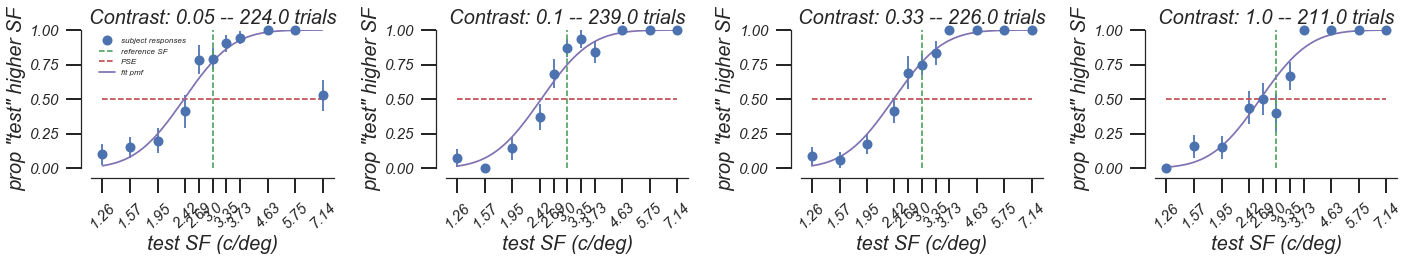

In [47]:
figPMF, allPMF = plt.subplots(1, 4, figsize=(20, 4));
# now plot the PMF

sns.set_style('white')
sns.despine(offset=10);

for c in range(nCons):
    whichCon = c;
    x = np.log2(np.arange(sfVals[0], sfVals[-1], 1e-2));
    true_pmf = lambda params: params[2] + (1-2*params[2])*norm.cdf(x, *params[0:2])

    pts = allPMF[c].errorbar(np.log2(sfVals), ptSf[whichCon], yerr=bootPtSfstd[whichCon, :], clip_on=False, linestyle='none', marker='o');
    refSFline = allPMF[c].plot(np.log2([refSF, refSF]), [0, 1], '--'); 
    pse = allPMF[c].plot(np.log2([sfVals[0], sfVals[-1]]), [0.5, 0.5], '--')
    pmf = allPMF[c].plot(x, true_pmf(params[whichCon, :]), '-');
    allPMF[c].set_ylim([0, 1]);
    allPMF[c].set_xticks(np.log2(sfVals))
    allPMF[c].tick_params(labelsize=15, width=2, length=15, which='major')
    allPMF[c].tick_params(labelsize=0, width=0, length=0, which='minor')
    sfAsStr = [str(x) for x in np.round(sfVals, 2)];
    allPMF[c].set_xticklabels(sfAsStr, rotation='45')
    allPMF[c].set_xlabel('test SF (c/deg)');
    allPMF[c].set_ylabel('prop "test" higher SF');
    allPMF[c].set_title('Contrast: ' + str(conVals[whichCon]) + ' -- ' + str(sum(nTr[whichCon])) + ' trials');
    if c == 0:
        allPMF[c].legend((pts[0], refSFline[0], pse[0], pmf[0]), ('subject responses', 'reference SF', 'PSE', 'fit pmf'), loc='upper left', fontsize=8);


figPMF.tight_layout()

### Plot of subject bias and sensitivity

In [48]:
pse = np.zeros((len(conVals), 1));
evalSfs = np.arange(sfVals[0], sfVals[-1], 1e-3);
evalPmf = lambda params: params[2] + (1-2*params[2])*norm.cdf(evalSfs, *params[0:2]);
for con in range(len(conVals)):
    pse[con] = evalSfs[np.argmin(abs(evalPmf(params[con]) - 0.5))]

In [49]:
# Statistics on PSE bootstrapped values...
pOfInt = 0; # PSE
outerInd = len(conVals);
pValPSE = np.nan*np.ones((outerInd, outerInd));
for c in range(outerInd):
    for ci in range(len(conVals) - c-1):
        
        z, pValPSE[c, c+ci+1] = wilcoxon(paramsBoot[c, pOfInt, :], paramsBoot[c+ci+1, pOfInt, :]); # 0 is PSE
        pValPSE[c+ci+1, c] = pValPSE[c, c+ci+1]

In [50]:
print('Significant difference in bootstrap distributions of PSE? P value:')
upTri = np.triu(pValPSE);
np.set_printoptions(precision=4)
np.set_printoptions(suppress=False)
print(upTri)

Significant difference in bootstrap distributions of PSE? P value:
[[         nan   4.3526e-11   1.5240e-08   1.1351e-15]
 [  0.0000e+00          nan   6.3285e-02   5.6715e-10]
 [  0.0000e+00   0.0000e+00          nan   4.8137e-18]
 [  0.0000e+00   0.0000e+00   0.0000e+00          nan]]


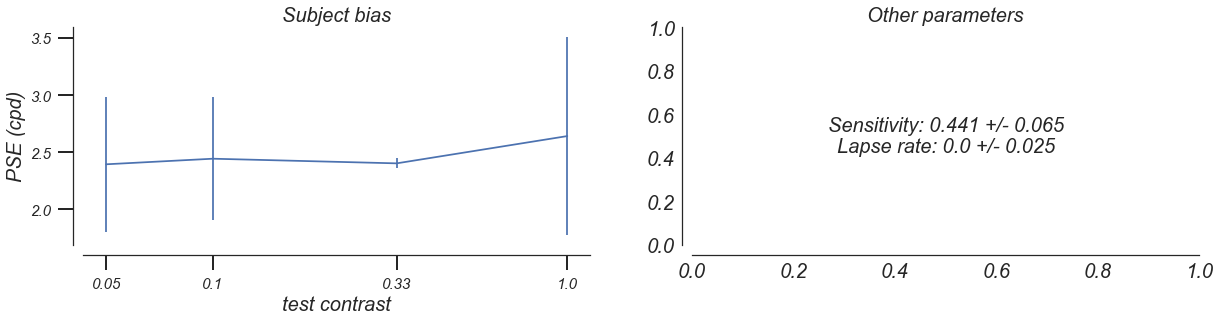

In [51]:
figParams, paramPlot = plt.subplots(1, 2, figsize=(20, 4));

sns.set_style('white')
sns.despine(offset=10);

paramPlot[0].errorbar(conVals, np.power(2, params[:, 0]), bootParamStd[:, 0]);
paramPlot[0].set_xscale('log');
paramPlot[0].set_xlabel('test contrast');
paramPlot[0].set_ylabel('PSE (cpd)');
paramPlot[0].set_title('Subject bias');
paramPlot[0].set_xticks(conVals);
paramPlot[0].tick_params(labelsize=15, width=2, length=15, which='major')
conAsStr = [str(x) for x in conVals];
paramPlot[0].set_xticklabels(conAsStr)

paramPlot[1].text(0.5, 0.55, 'Sensitivity: ' + str(np.round(params[0, 1], 3)) + ' +/- ' + 
                  str(np.round(bootParamStd[0, 1], 3)), horizontalalignment = 'center', verticalalignment = 'center');
paramPlot[1].text(0.5, 0.45, 'Lapse rate: ' + str(np.round(params[0, 2], 3)) + ' +/- ' + 
                  str(np.round(bootParamStd[0, 2], 3)), horizontalalignment = 'center', verticalalignment = 'center');
paramPlot[1].set_title('Other parameters');

In [52]:
allFigs = [figPMF, figParams];
if isGeorgeson:
    saveName = "results_D%dg.pdf" % disp
else:
    saveName = "results_D%d.pdf" % disp
pdf = pltSave.PdfPages(str(saveDir + saveName))
for fig in range(len(allFigs)): ## will open an empty extra figure :(
    pdf.savefig(allFigs[fig], bbox_inches="tight")
pdf.close()